# Financial Time Series Analysis – Log Returns and Risk Measures

This notebook presents an exploratory and statistical analysis of daily stock returns for selected companies from diversified sectors (BHP, Pfizer, LVMH).

The objective is to:
- analyse the statistical properties of log returns,
- assess distributional assumptions,
- identify outliers and autocorrelation,
- evaluate market risk using VaR and CVaR measures.

The analysis is designed as documentation-first and focuses on reproducibility and interpretability.

In [5]:
!pip install yfinance

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Tickers used in the analysis (Yahoo Finance notation)
tickers = {
    "BHP": "BHP",        # BHP Group Limited (NYSE)
    "Pfizer": "PFE",     # Pfizer Inc. (NYSE)
    "LVMH": "MC.PA"      # LVMH (Euronext Paris)
}

In [8]:
def download_stock_data(ticker, start="2015-01-01", end=None):
    """
    Downloads daily market data from Yahoo Finance and prepares it for analysis.

    Parameters:
        ticker (str): Yahoo Finance ticker symbol
        start (str): Start date (YYYY-MM-DD)
        end (str): End date (YYYY-MM-DD)

    Returns:
        pd.DataFrame: DataFrame with date, closing price, and log returns
    """
    df = yf.download(ticker, start=start, end=end, progress=False)

    if df.empty:
        raise ValueError(f"No data downloaded for ticker: {ticker}")

    df = df.reset_index()
    df = df.rename(columns={
        "Date": "Data",
        "Close": "Zamkniecie"
    })

    df["Log_Return"] = np.log(df["Zamkniecie"] / df["Zamkniecie"].shift(1))
    return df.dropna()


## Data Source

Market data is downloaded automatically from Yahoo Finance using the `yfinance` library.
The analysis uses daily closing prices and logarithmic returns.

In [9]:
# Download and store data for all analysed stocks
data = {}

for name, ticker in tickers.items():
    data[name] = download_stock_data(ticker)

# Quick check
for name, df in data.items():
    print(f"{name}: {df.shape[0]} observations")


/tmp/ipython-input-3957313976.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)
/tmp/ipython-input-3957313976.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)
/tmp/ipython-input-3957313976.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


BHP: 2754 observations
Pfizer: 2755 observations
LVMH: 2806 observations


## Closing Price Time Series – BHP

The chart presents the evolution of daily closing prices over the analysed period.
It highlights long-term trends and periods of increased volatility.


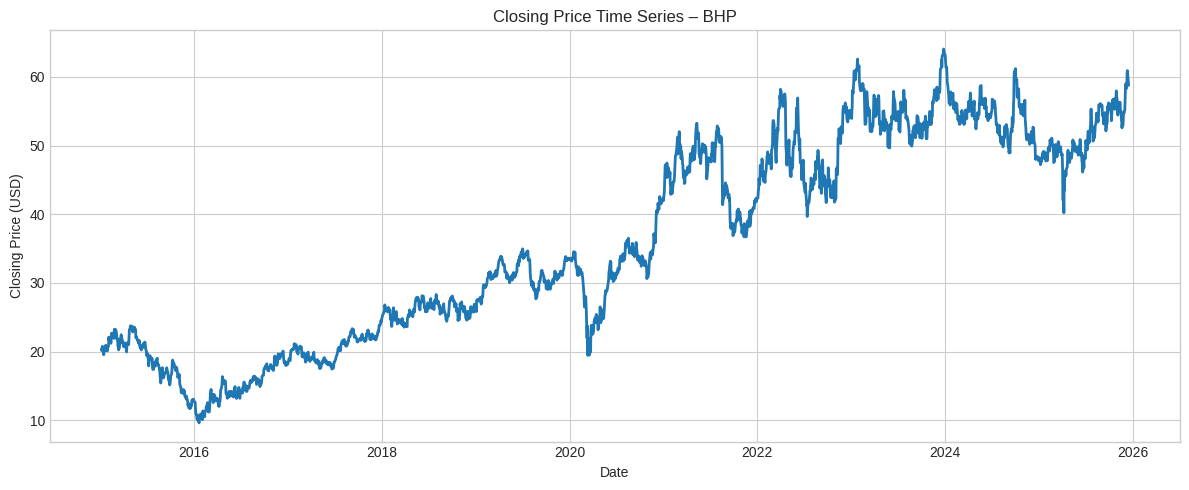

In [14]:
def plot_price_series(df, stock_name, currency):
    plt.figure(figsize=(12, 5))
    plt.plot(df["Data"], df["Zamkniecie"], linewidth=2)
    plt.title(f"Closing Price Time Series – {stock_name}")
    plt.xlabel("Date")
    plt.ylabel(f"Closing Price ({currency})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_price_series(
    df=data["BHP"],
    stock_name="BHP",
    currency="USD"
)


## Logarithmic Returns – BHP

Logarithmic returns are used to analyse relative price changes over time.
They stabilise variance and allow for meaningful statistical analysis of financial time series.

The chart below presents daily log returns for BHP, highlighting volatility clustering
and the presence of extreme observations.


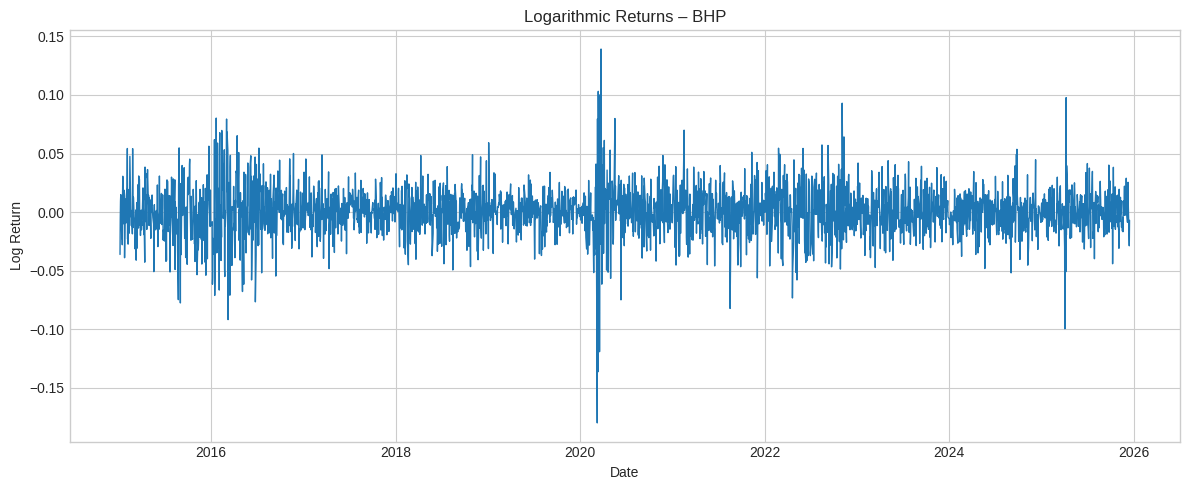

In [17]:
def plot_log_returns(df, stock_name):
    plt.figure(figsize=(12, 5))
    plt.plot(df["Data"], df["Log_Return"], linewidth=1)
    plt.title(f"Logarithmic Returns – {stock_name}")
    plt.xlabel("Date")
    plt.ylabel("Log Return")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_log_returns(
    df=data["BHP"],
    stock_name="BHP"
)


## Distribution of Log Returns and Outliers – BHP

This section examines the distribution of logarithmic returns using a boxplot
and identifies extreme observations based on the interquartile range (IQR) method.


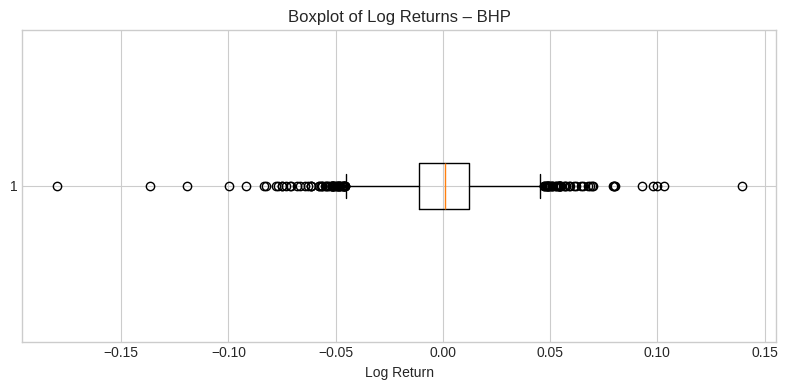

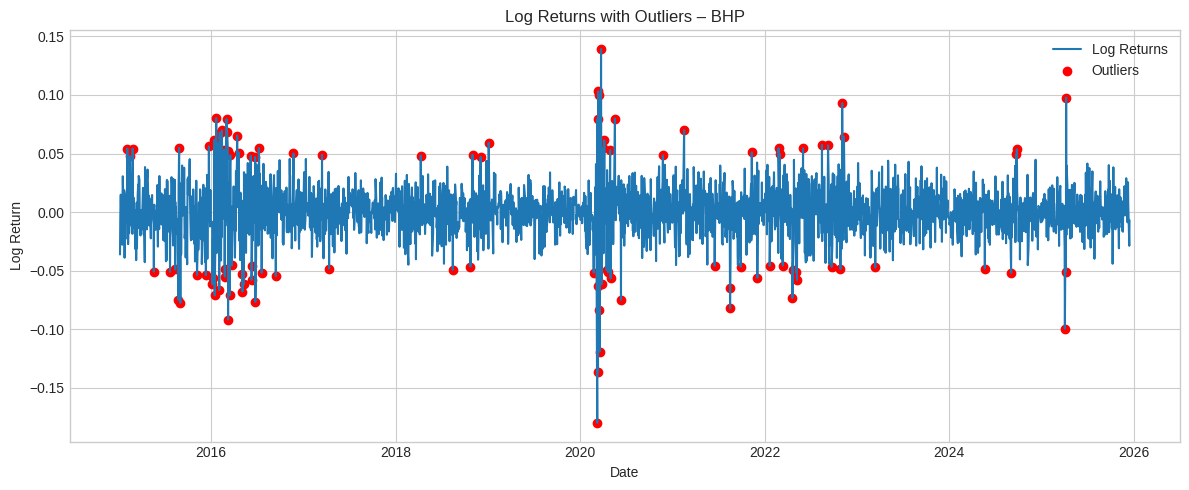

In [19]:
def plot_boxplot_and_outliers(df, stock_name):
    log_returns = df["Log_Return"]

    # Boxplot
    plt.figure(figsize=(8, 4))
    plt.boxplot(log_returns, vert=False)
    plt.title(f"Boxplot of Log Returns – {stock_name}")
    plt.xlabel("Log Return")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # IQR method
    Q1 = log_returns.quantile(0.25)
    Q3 = log_returns.quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df["Log_Return"] < lower) | (df["Log_Return"] > upper)]

    plt.figure(figsize=(12, 5))
    plt.plot(df["Data"], df["Log_Return"], label="Log Returns")
    plt.scatter(outliers["Data"], outliers["Log_Return"], color="red", label="Outliers")
    plt.title(f"Log Returns with Outliers – {stock_name}")
    plt.xlabel("Date")
    plt.ylabel("Log Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_boxplot_and_outliers(data["BHP"], "BHP")


## Distributional Properties and Normality – BHP

The following analysis evaluates the shape of the return distribution
and assesses the normality assumption using graphical and statistical methods.


BHP – Descriptive Statistics
Mean: 0.000373
Std: 0.021099
Skewness: -0.306
Kurtosis: 5.079


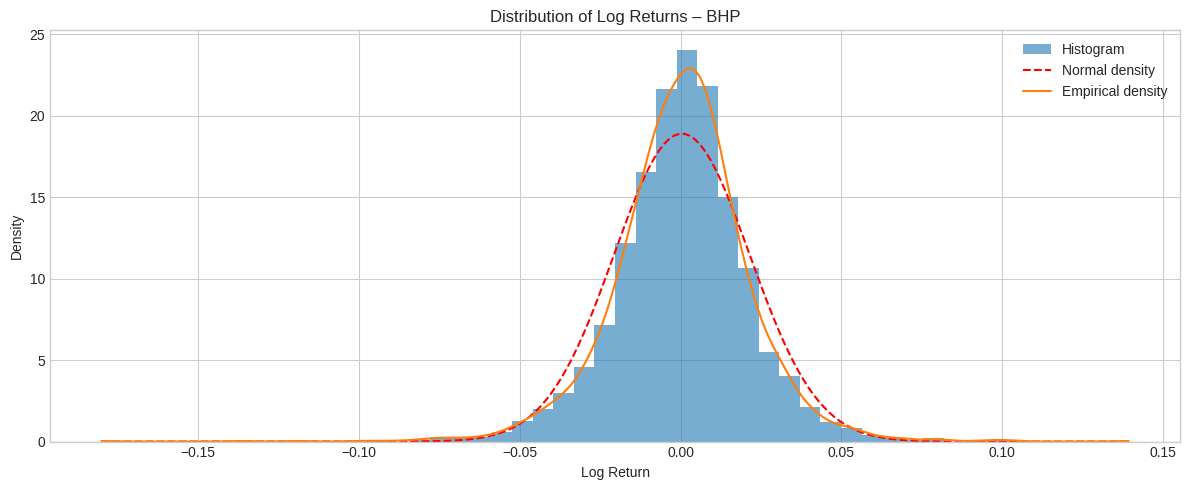

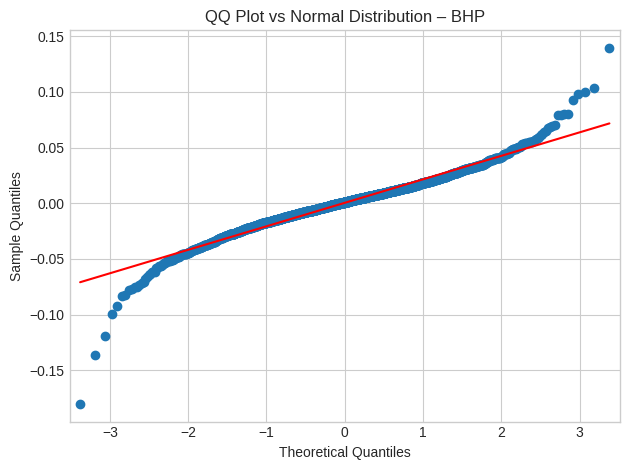

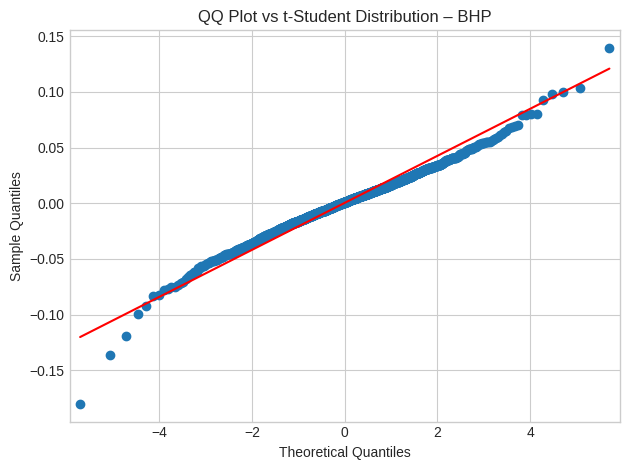

Jarque-Bera p-value: 0.0000
Kolmogorov-Smirnov p-value: 0.0000


In [20]:
from scipy.stats import norm, gaussian_kde, jarque_bera, kstest, t
import statsmodels.api as sm

def distribution_analysis(df, stock_name):
    r = df["Log_Return"]

    mean, std = r.mean(), r.std()
    skew, kurt = r.skew(), r.kurt()

    print(f"{stock_name} – Descriptive Statistics")
    print(f"Mean: {mean:.6f}")
    print(f"Std: {std:.6f}")
    print(f"Skewness: {skew:.3f}")
    print(f"Kurtosis: {kurt:.3f}")

    x = np.linspace(r.min(), r.max(), 200)

    plt.figure(figsize=(12, 5))
    plt.hist(r, bins=50, density=True, alpha=0.6, label="Histogram")
    plt.plot(x, norm.pdf(x, mean, std), "r--", label="Normal density")
    plt.plot(x, gaussian_kde(r)(x), label="Empirical density")
    plt.title(f"Distribution of Log Returns – {stock_name}")
    plt.xlabel("Log Return")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # QQ plots
    sm.qqplot(r, line="s")
    plt.title(f"QQ Plot vs Normal Distribution – {stock_name}")
    plt.tight_layout()
    plt.show()

    sm.qqplot(r, dist=t, distargs=(7,), line="s")
    plt.title(f"QQ Plot vs t-Student Distribution – {stock_name}")
    plt.tight_layout()
    plt.show()

    # Normality tests
    jb_p = jarque_bera(r)[1]
    ks_p = kstest(r, "norm")[1]

    print(f"Jarque-Bera p-value: {jb_p:.4f}")
    print(f"Kolmogorov-Smirnov p-value: {ks_p:.4f}")
distribution_analysis(data["BHP"], "BHP")


## Autocorrelation Analysis – BHP

This section investigates serial dependence in prices and log returns
using autocorrelation functions and the Ljung–Box test.

<Figure size 1000x400 with 0 Axes>

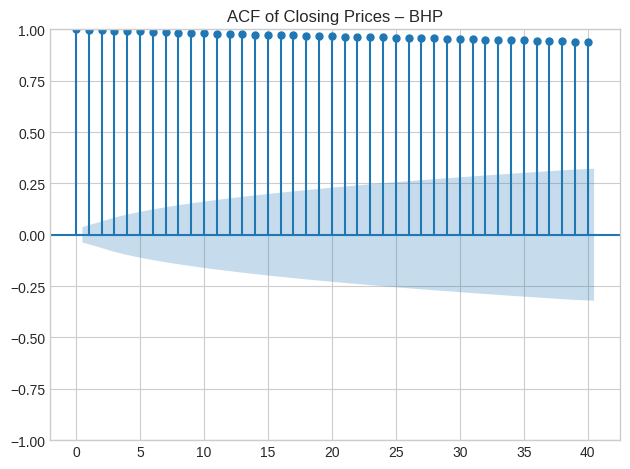

<Figure size 1000x400 with 0 Axes>

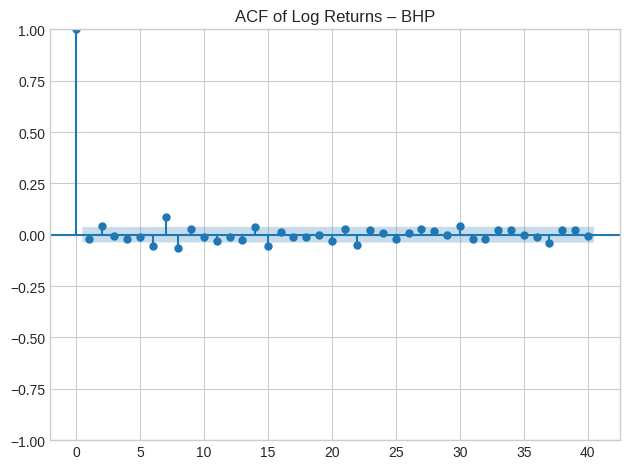

Ljung–Box p-value (prices): 0.0
Ljung–Box p-value (returns): 7.836611610552122e-08


In [21]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

def autocorrelation_analysis(df, stock_name):
    plt.figure(figsize=(10, 4))
    plot_acf(df["Zamkniecie"], lags=40)
    plt.title(f"ACF of Closing Prices – {stock_name}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plot_acf(df["Log_Return"], lags=40)
    plt.title(f"ACF of Log Returns – {stock_name}")
    plt.tight_layout()
    plt.show()

    lb_prices = acorr_ljungbox(df["Zamkniecie"], lags=40, return_df=True)
    lb_returns = acorr_ljungbox(df["Log_Return"], lags=40, return_df=True)

    print("Ljung–Box p-value (prices):", lb_prices["lb_pvalue"].iloc[-1])
    print("Ljung–Box p-value (returns):", lb_returns["lb_pvalue"].iloc[-1])
autocorrelation_analysis(data["BHP"], "BHP")


## Market Risk Measures – VaR and CVaR

Risk is assessed using both parametric and historical Value at Risk (VaR)
and Conditional Value at Risk (CVaR).


In [23]:
def calculate_var_cvar(log_returns, alpha=0.05):
    mean, std = log_returns.mean(), log_returns.std()

    var_param = norm.ppf(alpha, mean, std)
    cvar_param = mean - std * norm.pdf(norm.ppf(alpha)) / alpha

    var_hist = np.percentile(log_returns, 100 * alpha)
    cvar_hist = log_returns[log_returns <= var_hist].mean()

    return pd.Series({
        "VaR_parametric": var_param,
        "CVaR_parametric": cvar_param,
        "VaR_historical": var_hist,
        "CVaR_historical": cvar_hist
    })
risk_results = pd.DataFrame({
    stock: calculate_var_cvar(df["Log_Return"])
    for stock, df in data.items()
}).T

risk_results


,VaR_parametric,CVaR_parametric,VaR_historical,CVaR_historical
BHP,-0.034332,-0.043149,-0.033362,-0.048656
Pfizer,-0.024255,-0.030444,-0.022325,-0.033437
LVMH,-0.028480,-0.035876,-0.027232,-0.039711



===== BHP =====


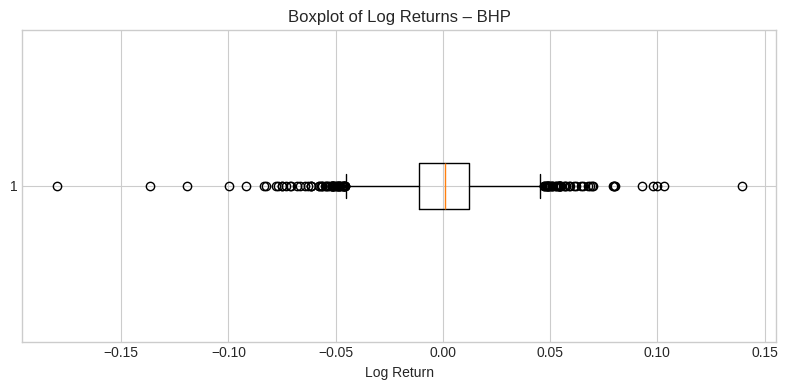

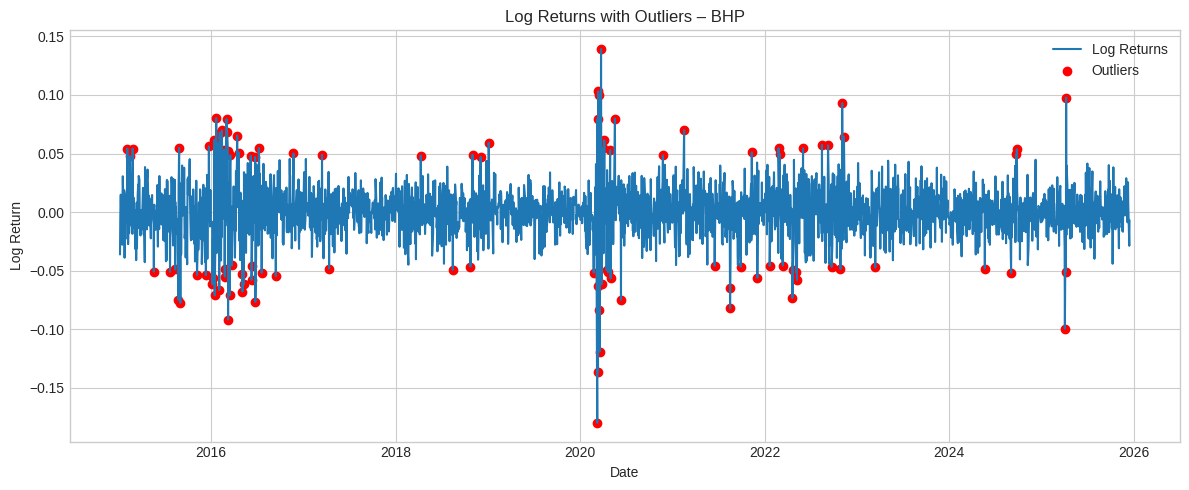

BHP – Descriptive Statistics
Mean: 0.000373
Std: 0.021099
Skewness: -0.306
Kurtosis: 5.079


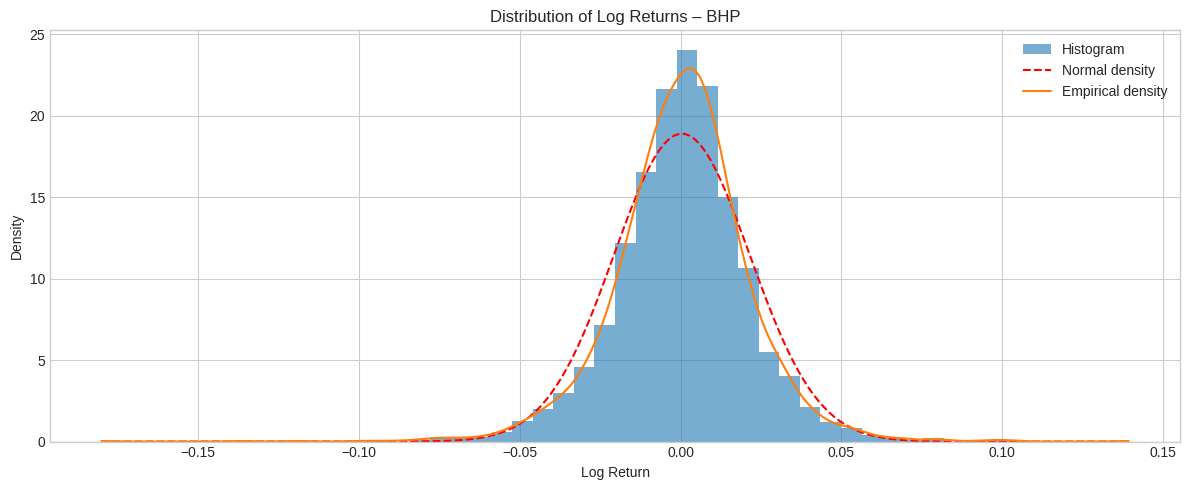

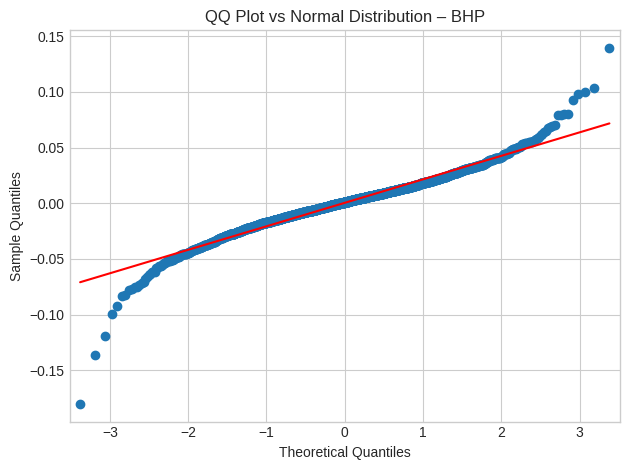

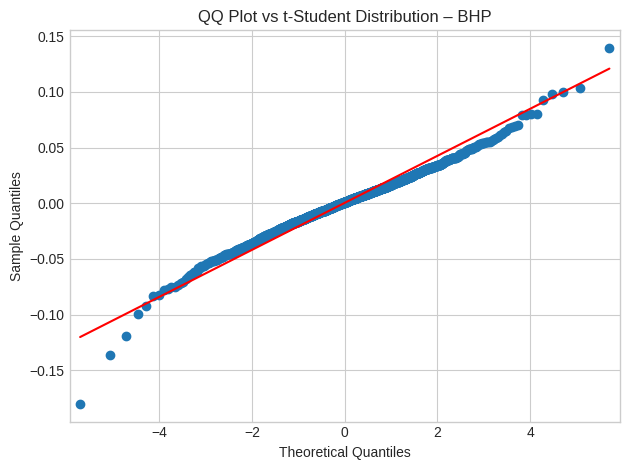

Jarque-Bera p-value: 0.0000
Kolmogorov-Smirnov p-value: 0.0000


<Figure size 1000x400 with 0 Axes>

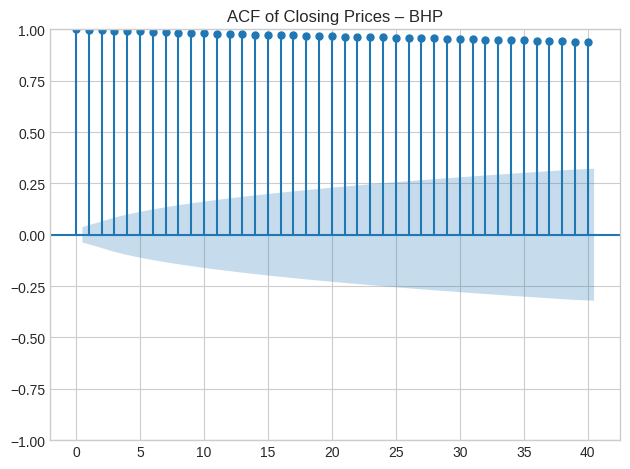

<Figure size 1000x400 with 0 Axes>

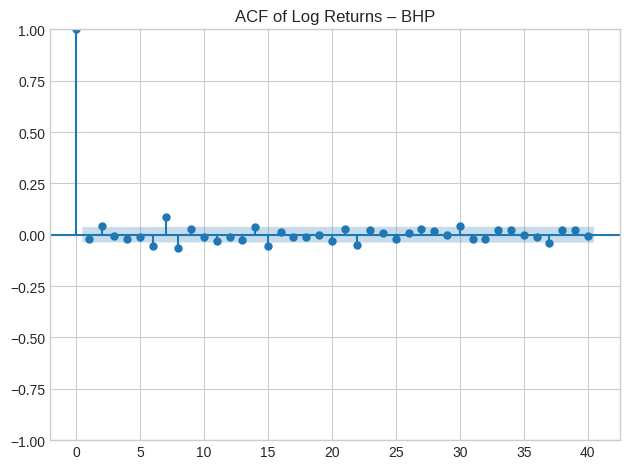

Ljung–Box p-value (prices): 0.0
Ljung–Box p-value (returns): 7.836611610552122e-08

===== Pfizer =====


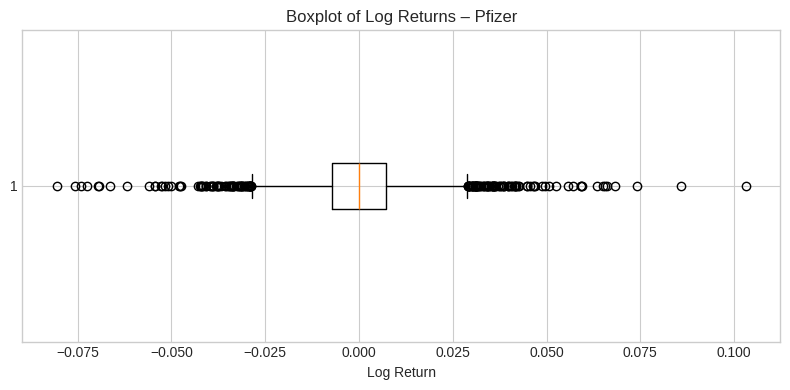

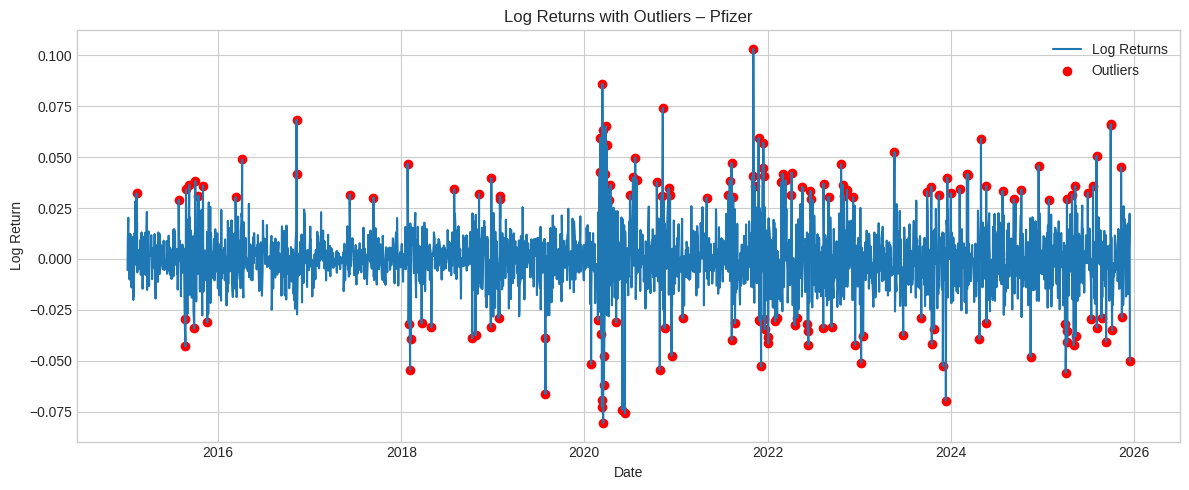

Pfizer – Descriptive Statistics
Mean: 0.000108
Std: 0.014811
Skewness: 0.153
Kurtosis: 4.430


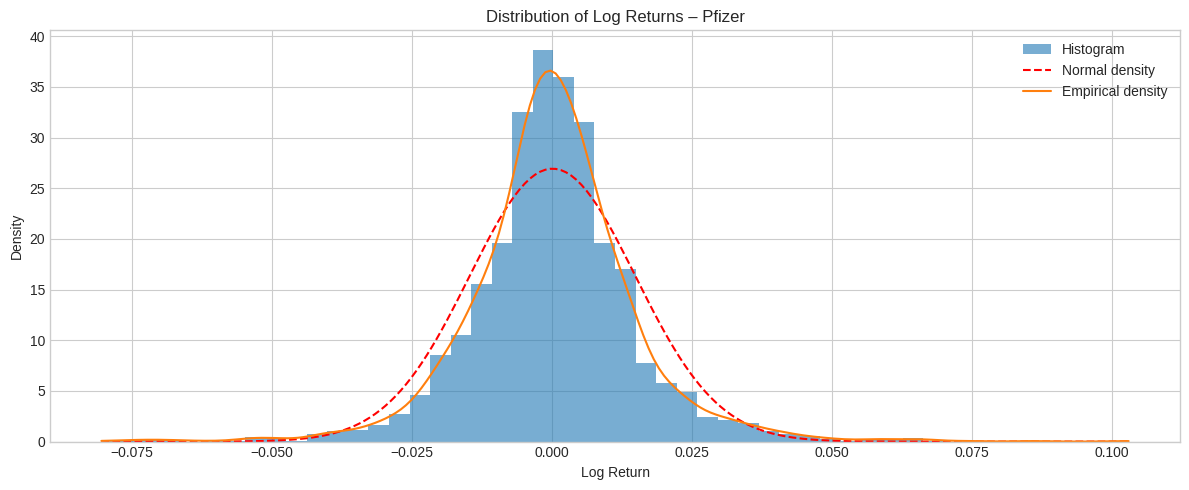

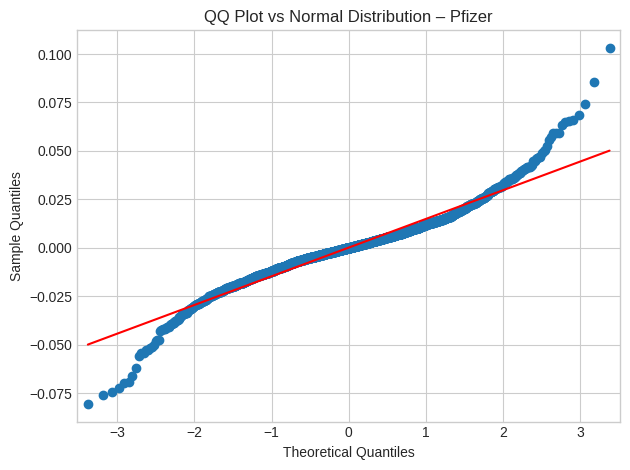

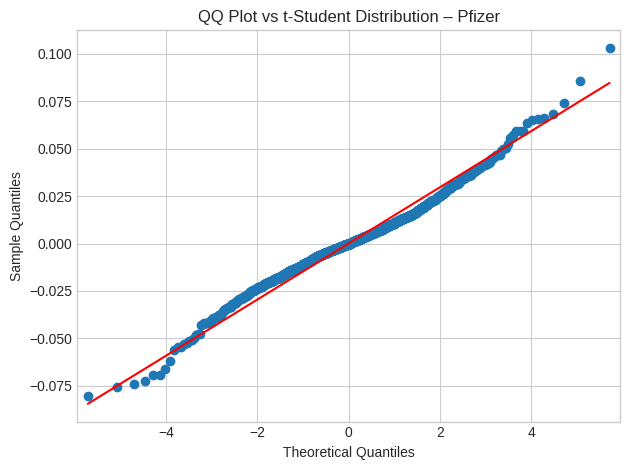

Jarque-Bera p-value: 0.0000
Kolmogorov-Smirnov p-value: 0.0000


<Figure size 1000x400 with 0 Axes>

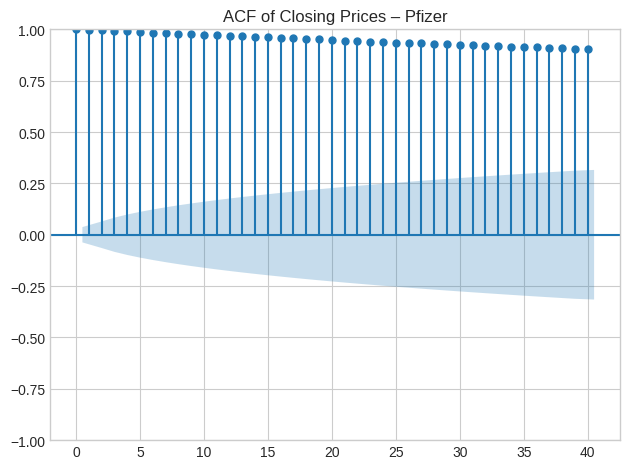

<Figure size 1000x400 with 0 Axes>

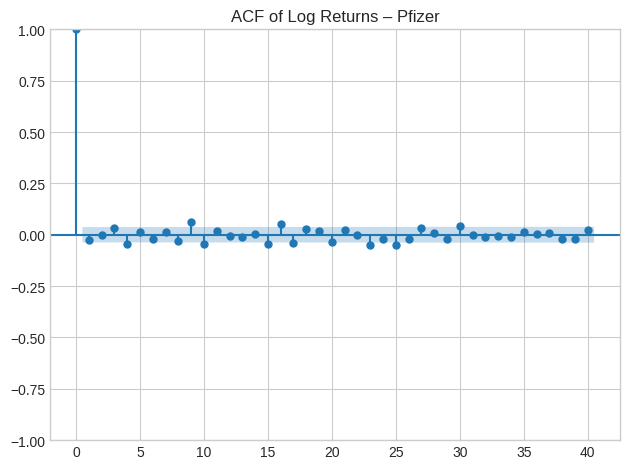

Ljung–Box p-value (prices): 0.0
Ljung–Box p-value (returns): 1.4301218684021081e-05

===== LVMH =====


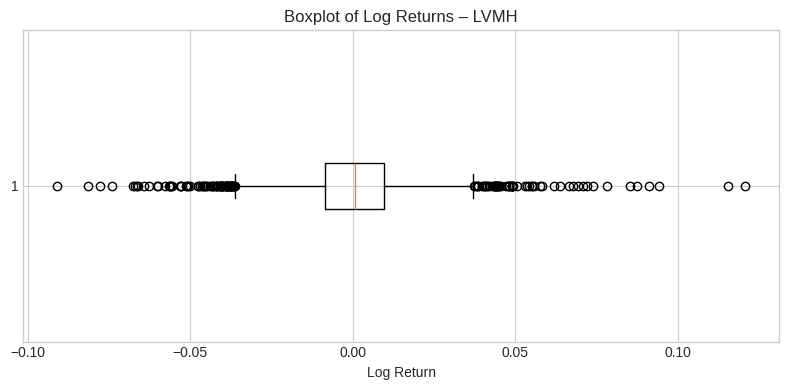

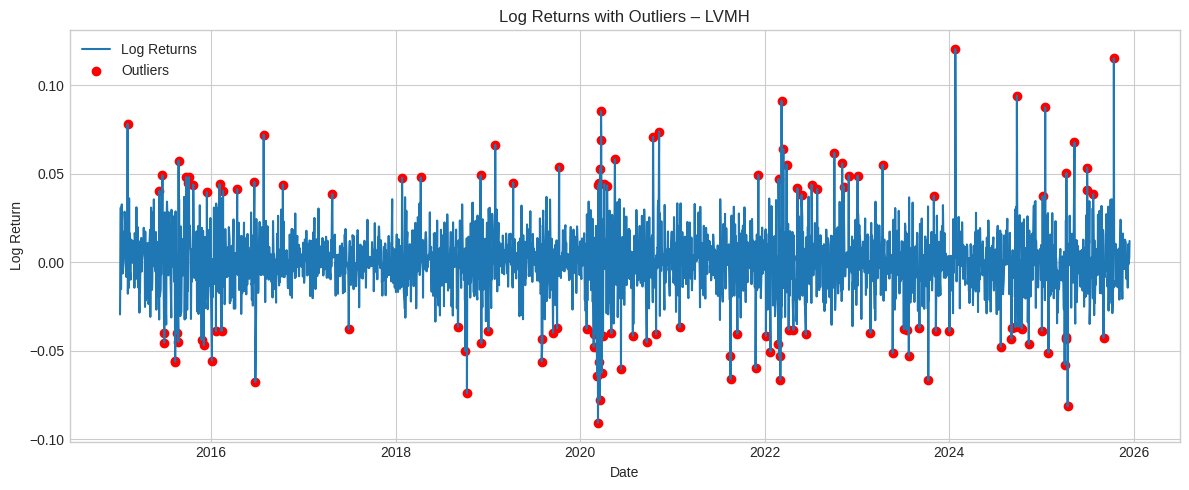

LVMH – Descriptive Statistics
Mean: 0.000632
Std: 0.017699
Skewness: 0.239
Kurtosis: 3.970


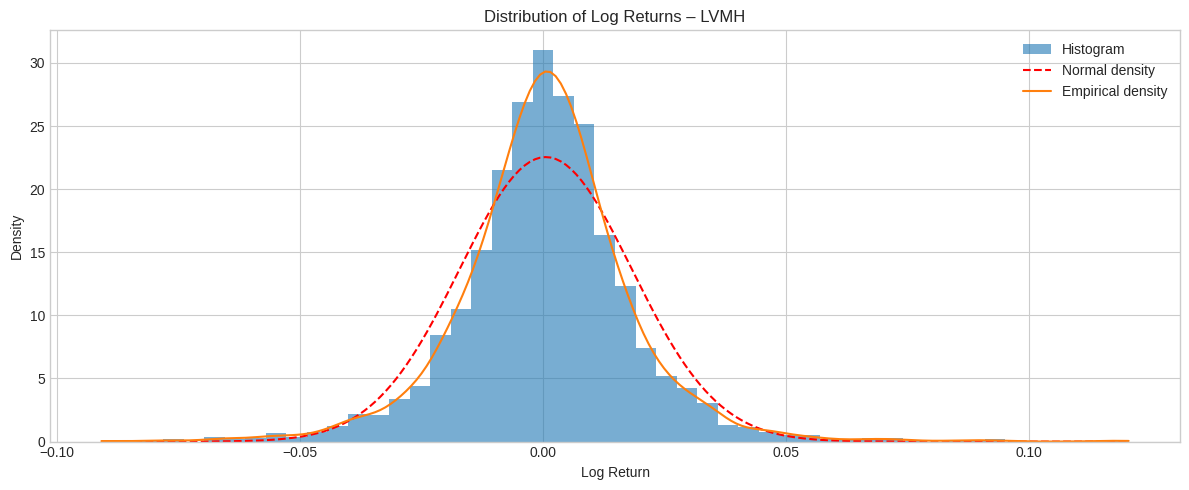

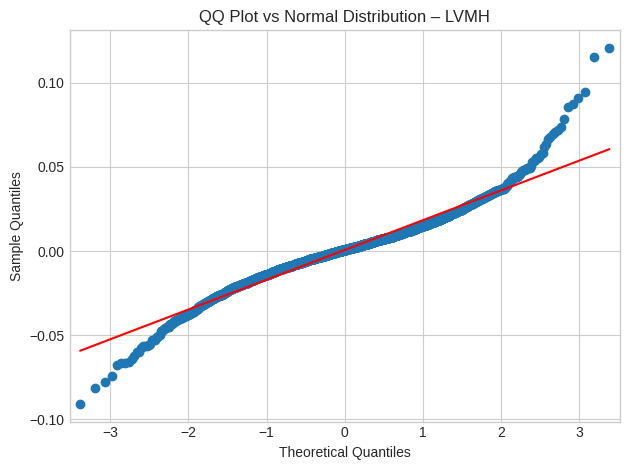

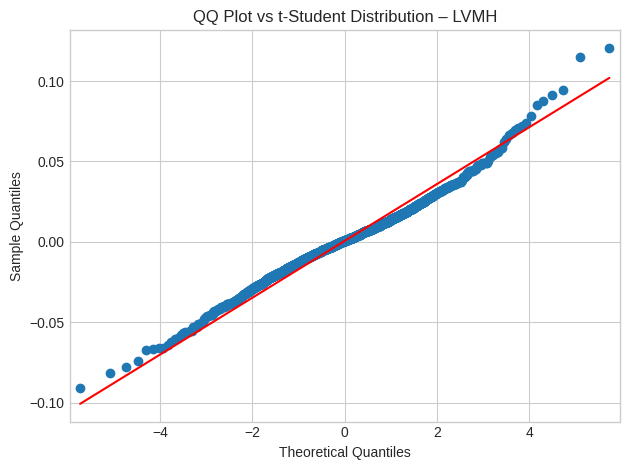

Jarque-Bera p-value: 0.0000
Kolmogorov-Smirnov p-value: 0.0000


<Figure size 1000x400 with 0 Axes>

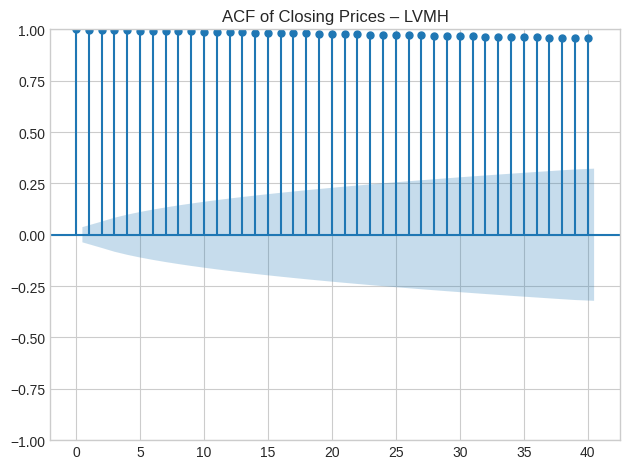

<Figure size 1000x400 with 0 Axes>

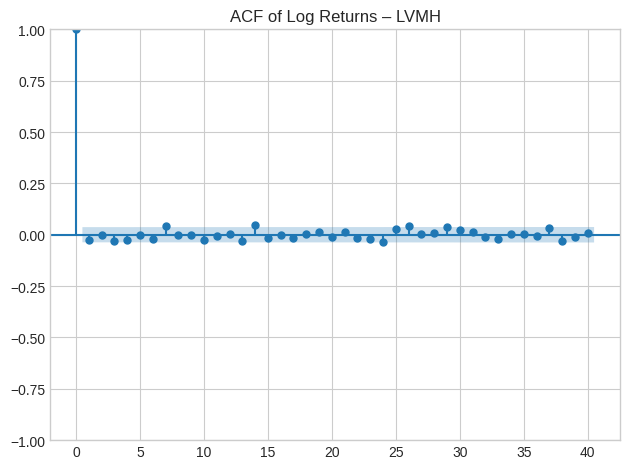

Ljung–Box p-value (prices): 0.0
Ljung–Box p-value (returns): 0.07899568868093756


In [24]:
for stock, df in data.items():
    print(f"\n===== {stock} =====")
    plot_boxplot_and_outliers(df, stock)
    distribution_analysis(df, stock)
    autocorrelation_analysis(df, stock)


## Conclusions

- Log returns for all analysed stocks deviate from normality and exhibit heavy tails.
- Extreme observations are present across assets, particularly during volatile periods.
- Price levels show strong autocorrelation, while log returns are largely weakly autocorrelated.
- Historical VaR and CVaR provide more conservative risk estimates than parametric measures.
- These findings highlight the importance of robust distributional assumptions in financial risk analysis.
